In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [7]:
learning_rate = 0.1
training_epochs = 5000
display_step = 100
n_idle_epochs = 1000
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=n_idle_epochs, min_delta=0.00001)

def scheduler(epoch, lr):
    if lr <= 0.01:
        return lr
    if epoch % 200 == 0:
        return lr * 0.8
        # return lr * 0.9   # best
    else:
        return lr
reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

class NEPOCHLogger(tf.keras.callbacks.Callback):
    def __init__(self, per_epoch=100):
        super(NEPOCHLogger, self).__init__()
        self.seen = 0
        self.per_epoch = per_epoch

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.per_epoch == 0:
            print('Epoch {}, loss {:.8f}, mae {:.8f}'.format(epoch, logs['loss'], logs['mae']))

log_display = NEPOCHLogger(per_epoch=display_step)
train_data = pd.read_csv(r'two_spiral_train_data.txt', header=None, sep='\s+')
test_data = pd.read_csv(r'two_spiral_test_data.txt', header=None, sep='\s+')
train_data['class_0'] = train_data[2].apply(lambda x: 1 if x == 0 else 0)
train_data['class_1'] = train_data[2].apply(lambda x: 1 if x == 1 else 0)
test_data['class_0'] = test_data[2].apply(lambda x: 1 if x == 0 else 0)
test_data['class_1'] = test_data[2].apply(lambda x: 1 if x == 1 else 0)

train_X = tf.convert_to_tensor(np.asarray(train_data.iloc[:, 0:2]))
train_y = tf.convert_to_tensor(np.asarray(train_data.iloc[:, 2]))
test_X = tf.convert_to_tensor(np.asarray(test_data.iloc[:, 0:2]))
test_y = tf.convert_to_tensor(np.asarray(test_data.iloc[:, 2]))

model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=128, input_shape=(2,), activation='swish'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.SGD(learning_rate)
model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

In [17]:
history = model.fit(train_X, train_y, epochs=training_epochs, verbose=0, batch_size=16, callbacks=[log_display, reduce_lr])
print("Train Finished!", history)
y_hat_train = model.predict(train_X, verbose=0)
y_hat_test = model.predict(test_X, verbose=0)
print('total number of test samples: %d' % len(test_y))
print(model.evaluate(test_X, test_y, verbose=0))

Epoch 0, loss 0.04744041, mae 0.06158236
Epoch 100, loss 0.04742779, mae 0.06159224
Epoch 200, loss 0.04739104, mae 0.06127080
Epoch 300, loss 0.04737832, mae 0.06104402
Epoch 400, loss 0.04737255, mae 0.06112982
Epoch 500, loss 0.04738780, mae 0.06125905
Epoch 600, loss 0.04736019, mae 0.06098677
Epoch 700, loss 0.04735382, mae 0.06083938
Epoch 800, loss 0.04735178, mae 0.06087771
Epoch 900, loss 0.04734821, mae 0.06084400
Epoch 1000, loss 0.04734546, mae 0.06080797
Epoch 1100, loss 0.04733854, mae 0.06077383
Epoch 1200, loss 0.04733725, mae 0.06076518
Epoch 1300, loss 0.04733363, mae 0.06071868
Epoch 1400, loss 0.04733167, mae 0.06070041
Epoch 1500, loss 0.04732483, mae 0.06064930
Epoch 1600, loss 0.04732261, mae 0.06061332
Epoch 1700, loss 0.04732234, mae 0.06061612
Epoch 1800, loss 0.04731968, mae 0.06056403
Epoch 1900, loss 0.04731972, mae 0.06058037
Epoch 2000, loss 0.04731713, mae 0.06055889
Epoch 2100, loss 0.04731728, mae 0.06056304
Epoch 2200, loss 0.04731550, mae 0.06055132


In [18]:
class_0_area, class_1_area = {}, {}
for x in np.arange(-6, 6.1, 0.5):
    for y in np.arange(-6, 6.1, 0.5):
        if model.predict([[x, y]], verbose=0)[0][0] > 0.5:
            class_1_area.setdefault('x', []).append(x)
            class_1_area.setdefault('y', []).append(y)
        else:
            class_0_area.setdefault('x', []).append(x)
            class_0_area.setdefault('y', []).append(y)

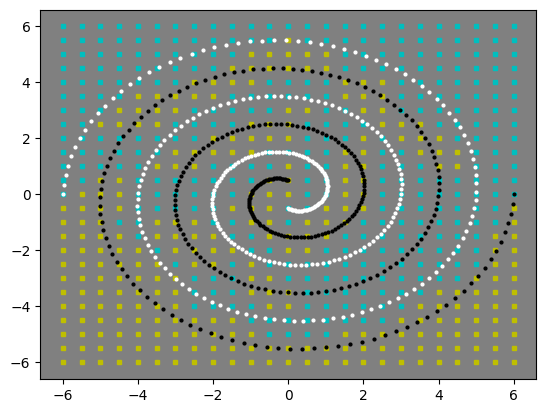

In [19]:
class_0, class_1 = {}, {}
for X, y in zip(np.concatenate([train_X.numpy(), test_X.numpy()], 0), np.concatenate([train_y.numpy(), test_y.numpy()], 0)):
    if y == 0:
        class_0.setdefault('x', []).append(X[0])
        class_0.setdefault('y', []).append(X[1])
    else:
        class_1.setdefault('x', []).append(X[0])
        class_1.setdefault('y', []).append(X[1])
plt.axes().set_facecolor('gray')
plt.plot(class_0_area['x'], class_0_area['y'], 'cs', markersize=3, label='class 0 area')
plt.plot(class_1_area['x'], class_1_area['y'], 'ys', markersize=3, label='class 1 area')
plt.plot(class_0['x'], class_0['y'], 'wo', markersize=2, label='class 0')
plt.plot(class_1['x'], class_1['y'], 'o', markersize=2, color='#000000', label='class 1')
plt.show()